## Imports

In [ ]:
import pandas as pd
import chardet
import numpy as np
from tqdm import tqdm
from datetime import timedelta
import pickle
from google.colab import drive

#model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#api request
import json
import requests

import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
from functools import lru_cache
from scipy.interpolate import interp1d # for transfering font size
import time
import geopandas
import matplotlib.pyplot as plt
import warnings
from geopy.geocoders import Nominatim
from pandas._libs.tslibs.offsets import YearEnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive


## Connect To Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Get Data + API Call

In [ ]:

dict_stations = {
'mizpe_ramon': [69, 379, 265, 296],
'avdat': [271, 335],
'sede_boker': [98],
'arad': [29, 240],
'beer_sheva': [59, 293, 60, 411, 412]
}
new_list = []
for k, v in dict_stations.items():
    for i in v:
        url = f"https://api.ims.gov.il/v1/envista/stations/{i}"
        headers = {'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'}
        response = requests.get(url, headers=headers)
        data = json.loads(response.text.encode('utf8'))
        new_list.append((k, data['name'], data['location']))


## Functions

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/data/10min_data/arad_station_10min_rain_01092000_01062001.csv")
def one_df_10min_to_monthly(df):
  df[['rain_amount', 'temperature','humidity']] = df[['rain_amount', 'temperature','humidity']].clip(lower=0)
  #df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce').fillna(0)

  df['start_rain'] = pd.to_datetime(df['start_rain'], format='%d/%m/%Y %H:%M')

  # Create new columns for 'month', 'year', and 'day' from 'start_rain' column
  df['month'] = df['start_rain'].dt.month
  df['year'] = df['start_rain'].dt.year

  # Group the DataFrame by 'year' and 'month', then aggregate the data
  aggregated_df = df.groupby(['year', 'month']).agg({
      'rain_amount': 'sum',
      'temperature': 'mean',
      'humidity': 'mean'
  }).reset_index()

  # Optionally, you can format the 'year' and 'month' columns as desired
  aggregated_df['year'] = aggregated_df['year'].astype(str)
  aggregated_df['month'] = aggregated_df['month'].apply(lambda x: '{:02d}'.format(x))

  # Combine 'year' and 'month' into a new 'month_year' column if needed
  aggregated_df['month_year'] = aggregated_df['year'] + '-' + aggregated_df['month']

  # Drop 'year' and 'month' columns if 'month_year' is used
  aggregated_df.drop(['year', 'month'], axis=1, inplace=True)

  return aggregated_df

In [ ]:
def aggregate_data(df, group_by):
    grouped = df.groupby(group_by).agg({
        'rain_amount': 'sum',
        'temperature': 'mean',
        'humidity': 'mean'
    }).reset_index()

    return grouped

In [ ]:
def many_df_10min_to_monthly(name_station, group_by='month'):
  df_monthly = pd.DataFrame()
  for year in tqdm(range(2000, 2022)):
    try:
      df_i = pd.read_csv(f"/content/drive/MyDrive/data/10min_data/{name_station}_station_10min_rain_0109{year}_0106{year+1}.csv")

      if 'faran' == name_station:
        df_i.rename(columns={
        'תחנה': 'rain_station',
        'תאריך ושעה (שעון קיץ)': 'start_rain',
        'לחות יחסית (%)': 'humidity',
        'טמפרטורה (C°)': 'temperature',
        'כמות גשם (מ"מ)': 'rain_amount'
        }, inplace=True)

      df_i = one_df_10min_to_monthly(df_i)
      df_monthly = pd.concat([df_monthly, df_i])
    except:
      pass
  df_monthly['month'] = pd.to_datetime(df_monthly['month_year'], format ='%Y-%m').dt.month
  df_monthly['year'] = pd.to_datetime(df_monthly['month_year'], format ='%Y-%m').dt.year
  df_monthly = df_monthly.drop_duplicates(subset='month_year')
  return aggregate_data(df_monthly, 'month')


In [ ]:
df_arad = many_df_10min_to_monthly('arad')
df_beer_sheva = many_df_10min_to_monthly('beer_sheva')
df_avdat = many_df_10min_to_monthly('avdat')
df_faran = many_df_10min_to_monthly('faran')
df_mizpe_ramon = many_df_10min_to_monthly('mizpe_ramon')
df_sede_boker = many_df_10min_to_monthly('sede_boker')

100%|██████████| 22/22 [00:09<00:00,  2.40it/s]


In [ ]:
# df_beer_sheva['rain_amount'] = df_beer_sheva['rain_amount'].apply(lambda x: 100 if x > 5000 else x)
# df_arad['humidity'], df_arad['temperature'] = df_arad['temperature'], df_arad['humidity']
# df_beer_sheva['humidity'], df_beer_sheva['temperature'] = df_beer_sheva['temperature'], df_beer_sheva['humidity']
# df_faran = df_faran[df_faran['month'] != 6]

In [ ]:
df_faran

,month,rain_amount,temperature,humidity,Location
0,1,12.4,12.494955,62.491947,Faran
1,2,9.0,14.590788,60.794679,Faran
2,3,0.0,19.394064,41.164427,Faran
3,4,0.0,21.881690,37.102546,Faran
4,5,1.5,27.524149,30.344086,Faran
6,9,0.0,28.647854,48.046625,Faran
7,10,0.0,25.363791,48.651947,Faran
8,11,3.8,19.785069,57.899537,Faran
9,12,0.0,14.498073,57.689068,Faran


## Visualization - Meteorological Stations

<ipython-input-125-60a03aba23e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faran['Location'] = 'Faran'


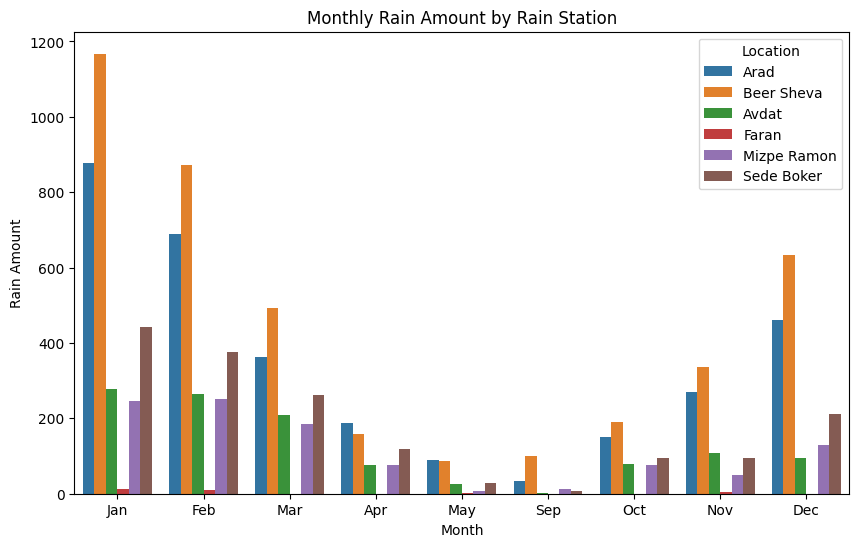

In [ ]:
# Add a 'Location' column to each dataframe
df_arad['Location'] = 'Arad'
df_beer_sheva['Location'] = 'Beer Sheva'
df_avdat['Location'] = 'Avdat'
df_faran['Location'] = 'Faran'
df_mizpe_ramon['Location'] = 'Mizpe Ramon'
df_sede_boker['Location'] = 'Sede Boker'

# Concatenate all dataframes into one
all_data = pd.concat([df_arad, df_beer_sheva, df_avdat, df_faran, df_mizpe_ramon, df_sede_boker])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x='month', y='rain_amount', hue='Location')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Rain Amount')
plt.title('Monthly Rain Amount by Rain Station')

# Set x-axis ticks to show all months (assuming 12 months)
plt.xticks(range(0,9), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Location')

# Show the plot
plt.show()


<ipython-input-129-5de81b32d66b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faran['Location'] = 'Faran'


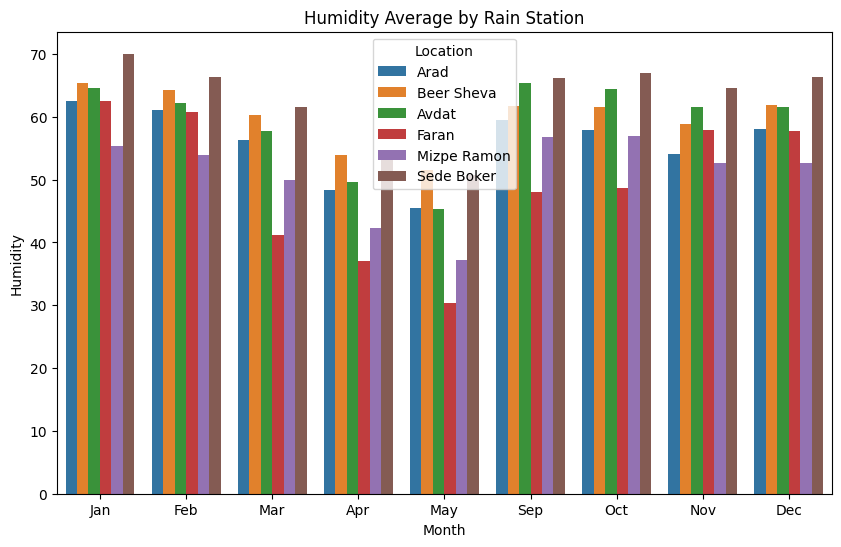

In [ ]:
# Add a 'Location' column to each dataframe
df_arad['Location'] = 'Arad'
df_beer_sheva['Location'] = 'Beer Sheva'
df_avdat['Location'] = 'Avdat'
df_faran['Location'] = 'Faran'
df_mizpe_ramon['Location'] = 'Mizpe Ramon'
df_sede_boker['Location'] = 'Sede Boker'

# Concatenate all dataframes into one
all_data = pd.concat([df_arad, df_beer_sheva, df_avdat, df_faran, df_mizpe_ramon, df_sede_boker])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x='month', y='humidity', hue='Location')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Humidity')
plt.title('Humidity Average by Rain Station')

# Set x-axis ticks to show all months (assuming 12 months)
plt.xticks(range(0,9), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Location')

# Show the plot
plt.show()


<ipython-input-128-cfecb985ee18>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faran['Location'] = 'Faran'


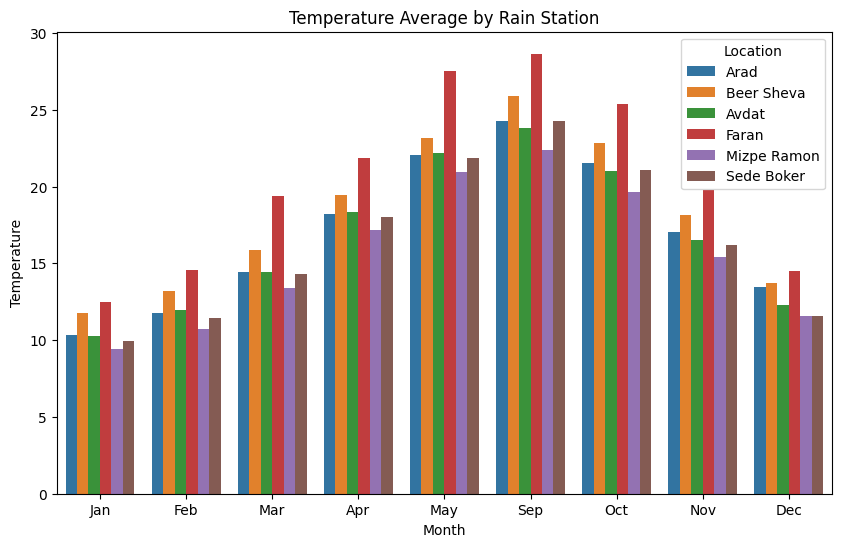

In [ ]:
# Add a 'Location' column to each dataframe
df_arad['Location'] = 'Arad'
df_beer_sheva['Location'] = 'Beer Sheva'
df_avdat['Location'] = 'Avdat'
df_faran['Location'] = 'Faran'
df_mizpe_ramon['Location'] = 'Mizpe Ramon'
df_sede_boker['Location'] = 'Sede Boker'

# Concatenate all dataframes into one
all_data = pd.concat([df_arad, df_beer_sheva, df_avdat, df_faran, df_mizpe_ramon, df_sede_boker])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x='month', y='temperature', hue='Location')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature Average by Rain Station')

# Set x-axis ticks to show all months (assuming 12 months)
plt.xticks(range(0,9), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Location')

# Show the plot
plt.show()


## Visualization - Hydraulic Stations

In [ ]:
def func_flow_in_river(file_csv, river_name):
  def detect_encoding(file_path):
      with open(file_path, 'rb') as f:
          result = chardet.detect(f.read())
      return result['encoding']
  flow_in_river_encoding = detect_encoding(file_csv)
  flow_in_river = pd.read_csv(file_csv, encoding=flow_in_river_encoding)
  flow_in_river = flow_in_river[['שם תחנה', 'שם תחנה באנגלית',  'זמן מדידת ספיקה',  '''ספיקה (מ''ק/שנייה)''']]
  flow_in_river.rename(columns={
      'שם תחנה': 'river_name_hebrew',
      'שם תחנה באנגלית': 'river_name_english',
      'זמן מדידת ספיקה': 'flow_time',
      '''ספיקה (מ''ק/שנייה)''': 'flow_amount'
  }, inplace=True)
  flow_in_river = flow_in_river[flow_in_river['river_name_hebrew'] == river_name]
  flow_in_river = flow_in_river[['river_name_hebrew', 'river_name_english', 'flow_time', 'flow_amount']]
  return flow_in_river

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/link_of_rain_station_to_river_preprocess.csv")
unique_values = data['נחל'].unique()
print(len(unique_values))
list_of_years = [(2000,2010),(2010,2019),(2019,2021)]

20


In [ ]:
flows = pd.DataFrame()
for tup in list_of_years:
  (y1,y2) = tup
  curr = pd.DataFrame()
  for river_name in tqdm(unique_values):
    dfi = func_flow_in_river(f"/content/drive/MyDrive/data/flow_in_river_{y1}_to_{y2}_hebrew.csv",river_name)
    curr = pd.concat([curr,dfi])
  flows = pd.concat([flows,curr])
flows.sort_values(by='river_name_english')

 30%|███       | 6/20 [00:17<00:39,  2.85s/it]<ipython-input-14-b72008e6435f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_in_river.rename(columns={
100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


,river_name_hebrew,river_name_english,flow_time,flow_amount
964006,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,21/02/2015 22:06,38.740
222726,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 18:50,0.594
222727,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 19:00,0.594
222728,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 19:40,0.396
222729,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 19:59,0.132
...,...,...,...,...
219357,צין-במעלה מפל,ZIN-UPSTREAM FROM WATERFALL,19/01/2020 3:54,0.673
219358,צין-במעלה מפל,ZIN-UPSTREAM FROM WATERFALL,19/01/2020 4:14,0.612
219359,צין-במעלה מפל,ZIN-UPSTREAM FROM WATERFALL,19/01/2020 4:39,0.520
219350,צין-במעלה מפל,ZIN-UPSTREAM FROM WATERFALL,19/01/2020 0:46,0.490


In [ ]:
flows = flows[flows['flow_amount']>0]

In [ ]:
list(flows['river_name_english'].unique())

['ZIHOR',
 'PARAN - ARAVA ROAD',
 'HIYON- 40 ROAD',
 "YA'ALON - KIBBUZ YAHAL",
 'RAMON',
 'NEQAROT - UPPER',
 "ZIN UPPER - 'AVEDAT",
 'NEQAROT - ARAVA ROAD',
 'ARAVA - EN YAHAV RESERVOIR',
 'ZIN - WATERFALL',
 'ZIN - MASOS',
 'TZIN - ARAVA ROAD',
 'BESOR - NEW NIZZANA ROAD',
 'HEMAR - DOWNSTREAM THE CLIFF',
 'RAHAF',
 "BE'ER-SHEVA - HAZERIM",
 'BESOR - REIM',
 "GERAR - RE'IM",
 'AROD',
 'ZIN-UPSTREAM FROM WATERFALL']

In [ ]:
flows.to_csv("/content/drive/MyDrive/data/flows_concatenated.csv",index = False, encoding = "")

<ipython-input-121-f563a824b317>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows['flow_time'] = pd.to_datetime(flows['flow_time'], format='%d/%m/%Y %H:%M')
<ipython-input-121-f563a824b317>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows['year'] = flows['flow_time'].dt.year


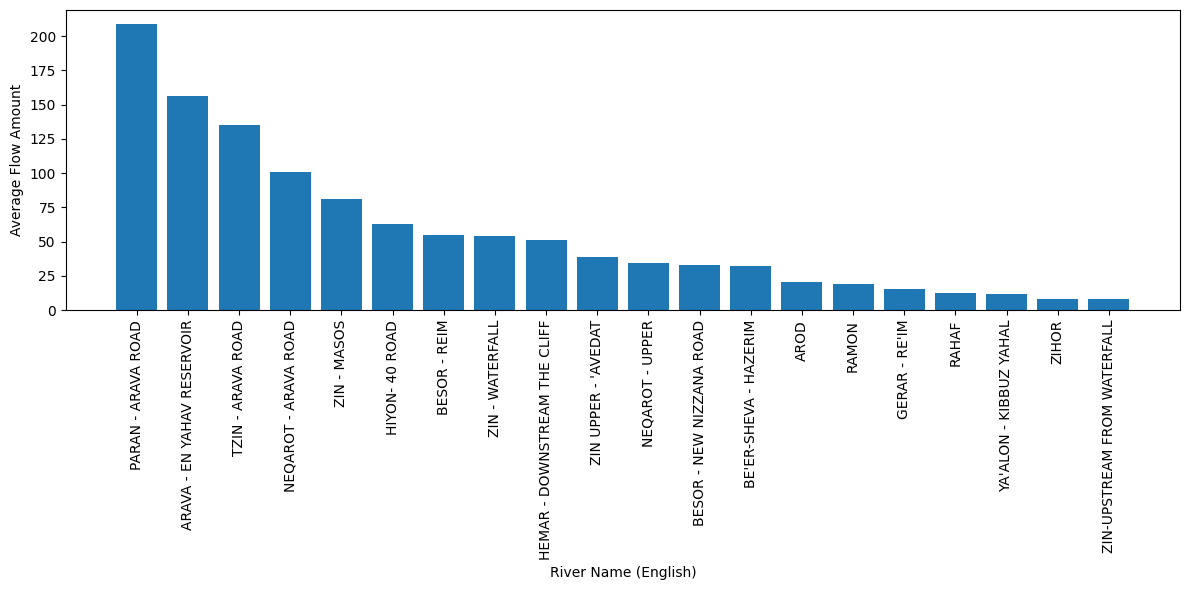

In [ ]:
flows['flow_time'] = pd.to_datetime(flows['flow_time'], format='%d/%m/%Y %H:%M')
flows['year'] = flows['flow_time'].dt.year
river_avg_flow = flows.groupby(['river_name_english', 'year'])['flow_amount'].mean().reset_index()
river_avg_flow_sorted = river_avg_flow.sort_values(by='flow_amount', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(river_avg_flow_sorted['river_name_english'], river_avg_flow_sorted['flow_amount'])
plt.xlabel('River Name (English)')
plt.ylabel('Average Flow Amount')
#plt.title('Average Flow Amount per Year by River (Descending Order)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
def plot_rivers_with_flow_by_month(df, year):
    # Step 1: Delete the 'flow_amount' column
    df = df.drop('flow_amount', axis=1)

    # Step 2: Create 'year' and 'month' features
    df['flow_time'] = pd.to_datetime(df['flow_time'], format='%d/%m/%Y %H:%M')
    df['year'] = df['flow_time'].dt.year
    df['month'] = df['flow_time'].dt.month

    # Step 3: Filter data for the specified year
    year_data = df[(df['year'] == year)]

    # Step 4: Pivot table to count the number of unique rivers flowing for each month
    pivot_table = pd.pivot_table(year_data, index='month', columns='river_name_english', aggfunc=lambda x: 1 if len(x.unique()) >= 1 else 0)

    # Fill NaN values with 0 (rivers with no flow)
    pivot_table = pivot_table.fillna(0).astype(int)
    # Ensure that all months from 1 to 12 are included in the DataFrame
    all_months = range(1, 13)
    pivot_table = pivot_table.reindex(all_months, fill_value=0)
    # Calculate the number of rivers with flow for each month

    monthly_counts = pivot_table.sum(axis=1)
    monthly_counts /= 3


    # Create the bar plot
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.figure(figsize=(10, 6))
    plt.bar(months, monthly_counts)
    plt.xlabel('Month')
    plt.ylabel('Number of Rivers with Flow')
    plt.title(f'{year} - Number of Rivers Flows per Month')
    plt.ylim(0, 20)  # Set y-axis range from 0 to 24
    plt.yticks([i for i in range(0,21)])
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig(f"{str(year)}.jpg", bbox_inches='tight')
    plt.close()

# Example usage:
# plot_rivers_with_flow_by_month(your_df, 2005)


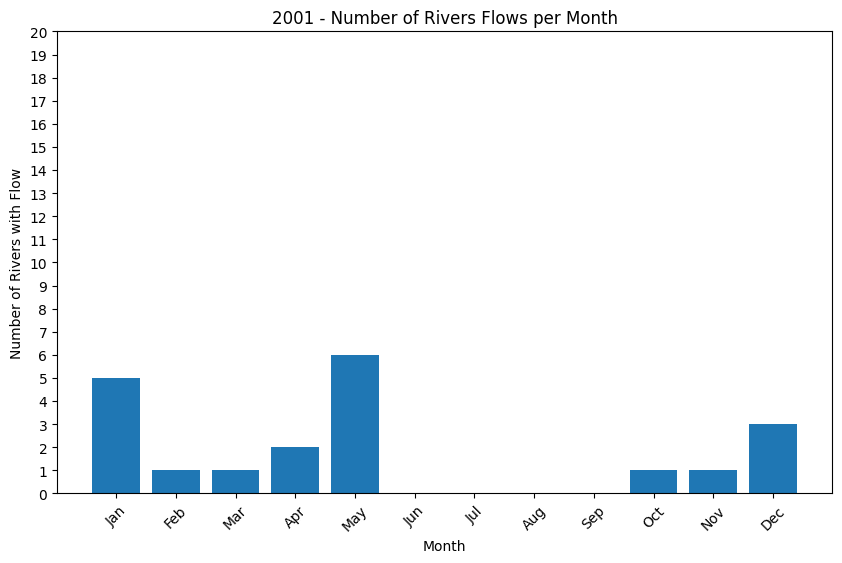

In [ ]:
plot_rivers_with_flow_by_month(flows, 2001)

In [ ]:
def plot_rivers_with_flow_by_year(df):
  pos = []
  for year in range(2000,2022):
    # Step 1: Delete the 'flow_amount' column
    #df = df.drop('flow_amount', axis=1)

    # Step 2: Create 'year' and 'month' features
    df['flow_time'] = pd.to_datetime(df['flow_time'], format='%d/%m/%Y %H:%M')
    df['year'] = df['flow_time'].dt.year
    df['month'] = df['flow_time'].dt.month

    # Step 3: Filter data for the specified year
    year_data = df[(df['year'] == year)]

    # Step 4: Pivot table to count the number of unique rivers flowing for each month
    pivot_table = pd.pivot_table(year_data, index='month', columns='river_name_english', aggfunc=lambda x: 1 if len(x.unique()) >= 1 else 0)

    # Fill NaN values with 0 (rivers with no flow)
    pivot_table = pivot_table.fillna(0).astype(int)
    # Ensure that all months from 1 to 12 are included in the DataFrame
    all_months = range(1, 13)
    pivot_table = pivot_table.reindex(all_months, fill_value=0)
    # Calculate the number of rivers with flow for each month

    monthly_counts = pivot_table.sum(axis=1)
    monthly_counts /= 3

    yearly_count = monthly_counts.sum(axis=0)
    pos.append(yearly_count)


  # Assuming 'pos' contains the yearly counts for each year from 2000 to 2021
  years = range(2000, 2021)
  pos = pos[:-1]

  plt.figure(figsize=(10, 6))
  plt.plot(years, pos, marker='o', linestyle='-')
  #plt.title('Number of Flows by Year (2000-2021)')
  plt.xlabel('Year')
  plt.ylabel('Number of Flows (Yearly Count)')
  plt.grid(True)
  plt.xticks(years, rotation=45)
  plt.tight_layout()

  plt.show()


# Example usage:
# plot_rivers_with_flow_by_month(your_df, 2005)


<ipython-input-101-814e0070e6d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flow_time'] = pd.to_datetime(df['flow_time'], format='%d/%m/%Y %H:%M')
<ipython-input-101-814e0070e6d2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['flow_time'].dt.year
<ipython-input-101-814e0070e6d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

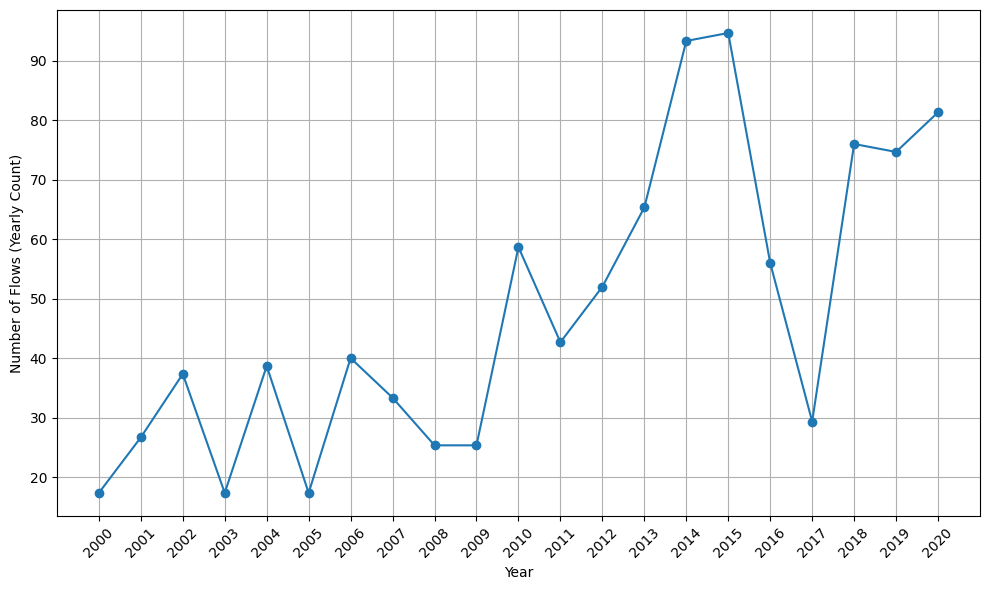

In [ ]:
plot_rivers_with_flow_by_year(flows)

## Visualization - Map Connections Stations - Rivers

In [ ]:
import pyproj
def convert_ITM_to_worldWide(itm_x, itm_y):

  # Define the ITM (Israeli Transverse Mercator) projection and WGS 84 (World Geodetic System 1984) projection
  itm = pyproj.Proj(init='epsg:2039')  # ITM projection
  wgs84 = pyproj.Proj(init='epsg:4326')  # WGS 84 projection (lat/lon)
  lon, lat = pyproj.transform(itm, wgs84, itm_x, itm_y)

  # Print the result
  return lat, lon

In [ ]:
#Get data by API
stations = [('Mizpe Ramon', 'MIZPE RAMON', {'latitude': 30.6125, 'longitude': 34.7967}),
('Avedat', 'AVDAT', {'latitude': 30.8, 'longitude': 34.77}),
('Sede Boqer', 'SEDE BOQER', {'latitude': 30.871, 'longitude': 34.796}),
('Arad', 'ARAD', {'latitude': 31.251, 'longitude': 35.186}),
('Beer Sheva', 'BEER SHEVA', {'latitude': 31.333, 'longitude': 34.783}),
('Faran', 'PARAN', {'latitude': 30.367, 'longitude': 35.148})]

In [ ]:
df_stations_locations = pd.DataFrame(columns=['location', 'geometry'])

for station in stations:
  a,b,c = station
  location = a
  geo = (c['latitude'], c['longitude'])
  df_stations_locations = df_stations_locations.append({'location': location, 'geometry': geo}, ignore_index=True)

<ipython-input-36-3172a8276776>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stations_locations = df_stations_locations.append({'location': location, 'geometry': geo}, ignore_index=True)
<ipython-input-36-3172a8276776>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stations_locations = df_stations_locations.append({'location': location, 'geometry': geo}, ignore_index=True)
<ipython-input-36-3172a8276776>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stations_locations = df_stations_locations.append({'location': location, 'geometry': geo}, ignore_index=True)
<ipython-input-36-3172a8276776>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [ ]:
df_stations_locations

,location,geometry
0,Mizpe Ramon,"(30.6125, 34.7967)"
1,Avedat,"(30.8, 34.77)"
2,Sede Boqer,"(30.871, 34.796)"
3,Arad,"(31.251, 35.186)"
4,Beer Sheva,"(31.333, 34.783)"
5,Faran,"(30.367, 35.148)"


In [ ]:
rivers = ['ZIHOR', 'PARAN - ARAVA ROAD', 'HIYON- 40 ROAD', "YA'ALON - KIBBUZ YAHAL", 'RAMON',
          'NEQAROT - UPPER', "ZIN UPPER - 'AVEDAT", 'NEQAROT - ARAVA ROAD', 'ARAVA - EN YAHAV RESERVOIR',
          'ZIN - WATERFALL', 'ZIN - MASOS', 'TZIN - ARAVA ROAD', 'BESOR - NEW NIZZANA ROAD', 'HEMAR - DOWNSTREAM THE CLIFF', 'RAHAF',
          "BE'ER-SHEVA - HAZERIM", 'BESOR - REIM', "GERAR - RE'IM", 'AROD', 'ZIN-UPSTREAM FROM WATERFALL']

In [ ]:
rivers_locations = pd.read_csv("/content/stations_longitude_latitude.csv")

In [ ]:
rivers_locations = rivers_locations[rivers_locations['שם אנגלית'].isin(rivers)]
rivers_locations = rivers_locations[['שם אנגלית', 'X .נ.צ', 'Y .נ.צ']]
rivers_locations

,שם אנגלית,X .נ.צ,Y .נ.צ
249,BESOR - NEW NIZZANA ROAD,170794.0,540542.0
270,BE'ER-SHEVA - HAZERIM,176178.0,570735.0
276,BESOR - REIM,147708.0,588428.0
280,GERAR - RE'IM,147291.0,590045.0
399,RAHAF,235683.0,578244.0
402,HEMAR - DOWNSTREAM THE CLIFF,233272.0,560366.0
410,ZIN UPPER - 'AVEDAT,178500.0,521000.0
411,ZIN-UPSTREAM FROM WATERFALL,177466.0,525546.0
412,ZIN - WATERFALL,177350.0,525800.0
413,ZIN - MASOS,198039.0,523638.0


In [ ]:
rivers_locations['Latitude'], rivers_locations['Longitude'] = zip(*rivers_locations.apply(lambda row: convert_ITM_to_worldWide(row['X .נ.צ'], row['Y .נ.צ']), axis=1))

In [ ]:
rivers_locations

,שם אנגלית,X .נ.צ,Y .נ.צ,Latitude,Longitude
249,BESOR - NEW NIZZANA ROAD,170794.0,540542.0,30.954829,34.695159
270,BE'ER-SHEVA - HAZERIM,176178.0,570735.0,31.227352,34.750211
276,BESOR - REIM,147708.0,588428.0,31.385510,34.450150
280,GERAR - RE'IM,147291.0,590045.0,31.400067,34.445649
399,RAHAF,235683.0,578244.0,31.295765,35.374872
402,HEMAR - DOWNSTREAM THE CLIFF,233272.0,560366.0,31.134552,35.349303
410,ZIN UPPER - 'AVEDAT,178500.0,521000.0,30.778863,34.776588
411,ZIN-UPSTREAM FROM WATERFALL,177466.0,525546.0,30.819830,34.765601
412,ZIN - WATERFALL,177350.0,525800.0,30.822117,34.764378
413,ZIN - MASOS,198039.0,523638.0,30.803170,34.980646


In [ ]:
# Add a new column manually
new_column_data = ['Sede Boqer', 'Beer Sheva', 'Beer Sheva', 'Beer Sheva', 'Arad', 'Arad', 'Avedat', 'Avedat', 'Avedat', 'Sede Boqer', 'Sede Boqer',
                   'Mizpe Ramon', 'Mizpe Ramon', 'Mizpe Ramon', 'Faran', 'Faran', 'Faran', 'Faran', 'Mizpe Ramon', 'Faran']  # Replace this with your data
new_column_name = 'station_name'  # Replace this with your desired column name

rivers_locations[new_column_name] = new_column_data

In [ ]:
rivers_locations

,שם אנגלית,X .נ.צ,Y .נ.צ,Latitude,Longitude,station_name
249,BESOR - NEW NIZZANA ROAD,170794.0,540542.0,30.954829,34.695159,Sede Boqer
270,BE'ER-SHEVA - HAZERIM,176178.0,570735.0,31.227352,34.750211,Beer Sheva
276,BESOR - REIM,147708.0,588428.0,31.385510,34.450150,Beer Sheva
280,GERAR - RE'IM,147291.0,590045.0,31.400067,34.445649,Beer Sheva
399,RAHAF,235683.0,578244.0,31.295765,35.374872,Arad
402,HEMAR - DOWNSTREAM THE CLIFF,233272.0,560366.0,31.134552,35.349303,Arad
410,ZIN UPPER - 'AVEDAT,178500.0,521000.0,30.778863,34.776588,Avedat
411,ZIN-UPSTREAM FROM WATERFALL,177466.0,525546.0,30.819830,34.765601,Avedat
412,ZIN - WATERFALL,177350.0,525800.0,30.822117,34.764378,Avedat
413,ZIN - MASOS,198039.0,523638.0,30.803170,34.980646,Sede Boqer


<ipython-input-56-1a74fd630d1b>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


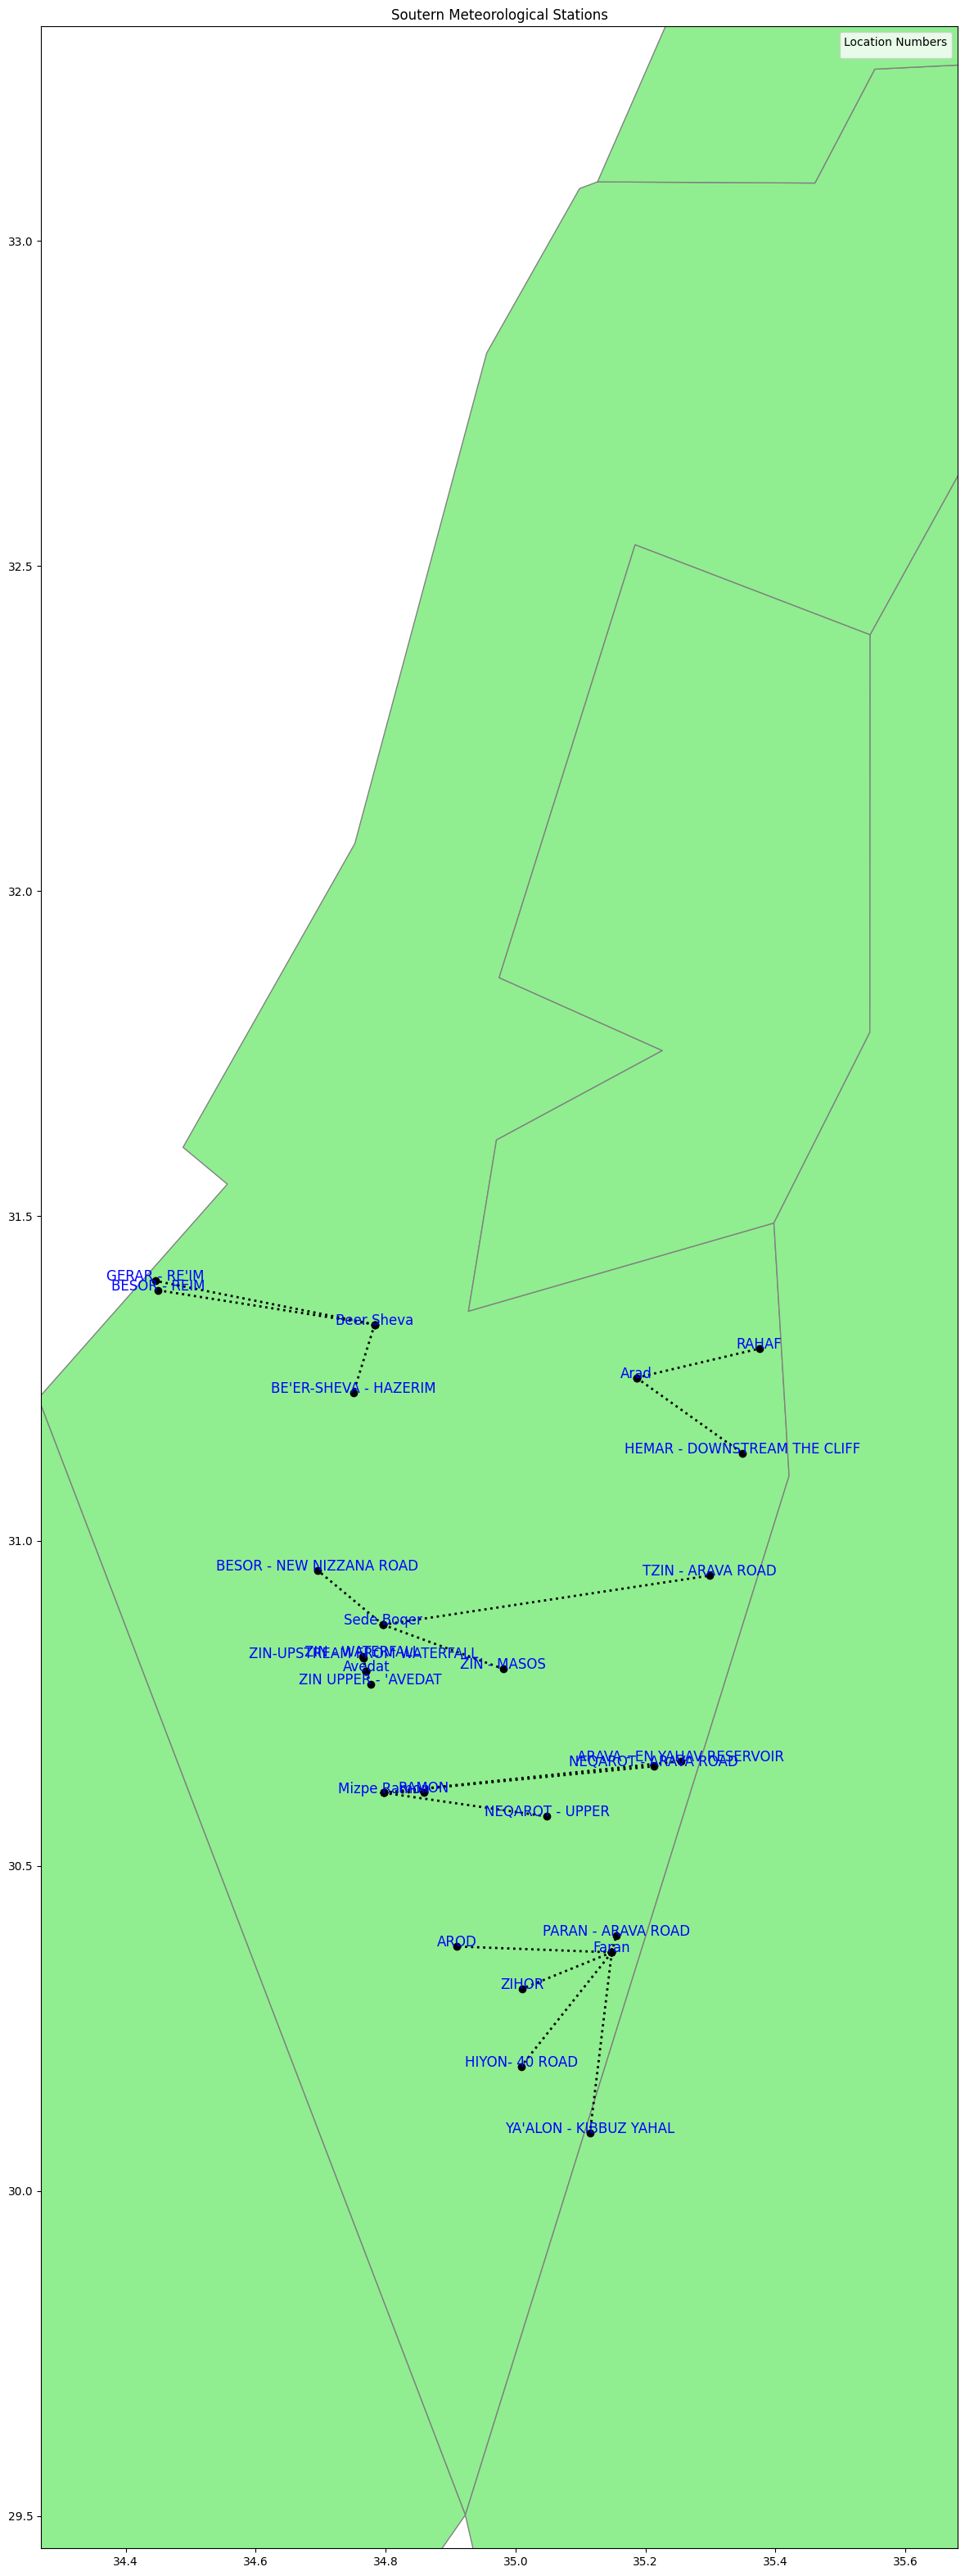

In [ ]:
def within_radius(point, existing_points, radius):
    for existing_point in existing_points:
        if point.distance(existing_point) <= radius:
            return True
    return False

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgreen', edgecolor='gray', figsize=(40, 40))

existing_points = []  # List to store existing points within thegiven radius
new_rows = []  # List to store rows that satisfy the condition

for idx, row in df_stations_locations.iterrows():
    pt = row['geometry']
    location = row['location']
    point = Point(pt[1], pt[0])

    if not within_radius(point, existing_points, 0.0005):
        new_rows.append(row)
        gdf = geopandas.GeoDataFrame({'location': [location], 'geometry': [point]})
        gdf.plot(ax=ax, marker='o', color='red', markersize=6)
        existing_points.append(point)  # Add the point to existing points list

        # Add label
        plt.annotate(text=location, xy=(pt[1], pt[0]), horizontalalignment='center', fontsize=12, color="blue")

for idx, row in rivers_locations.iterrows():
    pt = (row['Latitude'], row['Longitude'])
    location = row['שם אנגלית']
    point = Point(pt[1], pt[0])

    if not within_radius(point, existing_points, 0.0005):
        new_rows.append(row)
        gdf = geopandas.GeoDataFrame({'location': [location], 'geometry': [point]})
        gdf.plot(ax=ax, marker='o', color='red', markersize=6)
        existing_points.append(point)  # Add the point to existing points list

        # Add label
        plt.annotate(text=location, xy=(pt[1], pt[0]), horizontalalignment='center', fontsize=12, color="blue")

# Create a new DataFrame with the collected rows
new_df = geopandas.GeoDataFrame(new_rows)

# Add lines between the points
for i,row in rivers_locations.iterrows():
    try:
        station_geometry = df_stations_locations[df_stations_locations['location'] == row['station_name']]
        station_geometry = station_geometry['geometry'].values[0]
        station_name = row['station_name']
        river_name = row['שם אנגלית']
        river_geometry = (row['Latitude'], row['Longitude'])
        loc1, row1 = station_name, station_geometry
        loc2, row2 = river_name, river_geometry
        point1 = Point(row1[1], row1[0])
        point2 = Point(row2[1], row2[0])

        ax.plot([row1[1], row2[1]], [row1[0], row2[0]], color='black', linewidth=2,linestyle='dotted',marker='o')
    except:
        pass

# Set the plot limits to zoom in on USA and Europe
plt.legend(title="Location Numbers", loc='upper right')
ax.set_xlim(34.27, 35.68)  # Set x limits (longitude)
ax.set_ylim(29.45, 33.33)  # Set y limits (latitude)
ax.set_title("Soutern Meteorological Stations")
plt.show()


<ipython-input-57-8e483c1d619b>:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


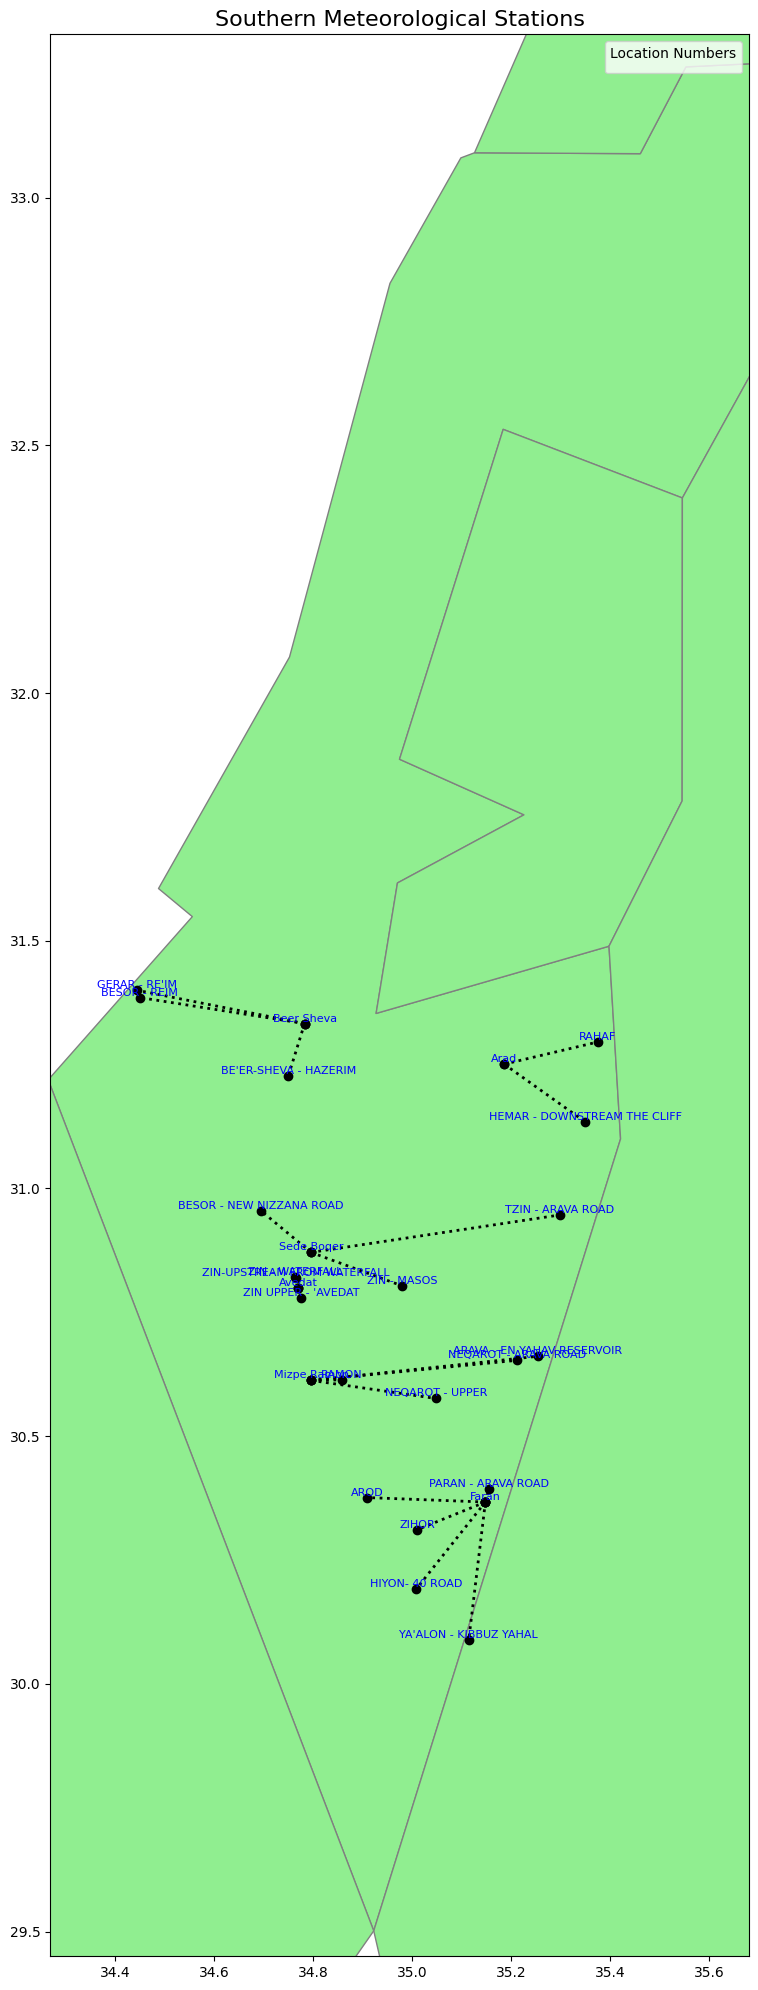

In [ ]:
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point

def within_radius(point, existing_points, radius):
    for existing_point in existing_points:
        if point.distance(existing_point) <= radius:
            return True
    return False

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgreen', edgecolor='gray', figsize=(20, 20))  # Decreased figure size

existing_points = []  # List to store existing points within the given radius
new_rows = []  # List to store rows that satisfy the condition

for idx, row in df_stations_locations.iterrows():
    pt = row['geometry']
    location = row['location']
    point = Point(pt[1], pt[0])

    if not within_radius(point, existing_points, 0.0005):
        new_rows.append(row)
        gdf = geopandas.GeoDataFrame({'location': [location], 'geometry': [point]})
        gdf.plot(ax=ax, marker='o', color='red', markersize=6)
        existing_points.append(point)  # Add the point to existing points list

        # Add label with adjusted fontsize and improved placement
        plt.annotate(text=location, xy=(pt[1], pt[0]), fontsize=8, color="blue", ha='center', va='bottom')

for idx, row in rivers_locations.iterrows():
    pt = (row['Latitude'], row['Longitude'])
    location = row['שם אנגלית']
    point = Point(pt[1], pt[0])

    if not within_radius(point, existing_points, 0.0005):
        new_rows.append(row)
        gdf = geopandas.GeoDataFrame({'location': [location], 'geometry': [point]})
        gdf.plot(ax=ax, marker='o', color='red', markersize=6)
        existing_points.append(point)  # Add the point to existing points list

        # Add label with adjusted fontsize and improved placement
        plt.annotate(text=location, xy=(pt[1], pt[0]), fontsize=8, color="blue", ha='center', va='bottom')

# Create a new DataFrame with the collected rows
new_df = geopandas.GeoDataFrame(new_rows)

# Add lines between the points
for i,row in rivers_locations.iterrows():
    try:
        station_geometry = df_stations_locations[df_stations_locations['location'] == row['station_name']]
        station_geometry = station_geometry['geometry'].values[0]
        station_name = row['station_name']
        river_name = row['שם אנגלית']
        river_geometry = (row['Latitude'], row['Longitude'])
        loc1, row1 = station_name, station_geometry
        loc2, row2 = river_name, river_geometry
        point1 = Point(row1[1], row1[0])
        point2 = Point(row2[1], row2[0])

        ax.plot([row1[1], row2[1]], [row1[0], row2[0]], color='black', linewidth=2, linestyle='dotted', marker='o')
    except:
        pass

# Set the plot limits to zoom in on USA and Europe
plt.legend(title="Location Numbers", loc='upper right')
ax.set_xlim(34.27, 35.68)  # Set x limits (longitude)
ax.set_ylim(29.45, 33.33)  # Set y limits (latitude)
ax.set_title("Southern Meteorological Stations", fontsize=16)  # Increased title fontsize
plt.tight_layout()  # Ensure that labels don't overlap
plt.show()
